# Aproximación de Born

Es posible ejecutar esta Jupyter Notebook localmente o en Google Colaboratory.

<p><a href="https://colab.research.google.com/github.com/rirastorza/Intro2MI/blob/master/metodos_deterministicos/metodo_Born.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>


## Introducción

Todo lo desarrollado aquí está basado en el libro de M. Pastorino (págs. 108-117).
Antes de comenzar con este método vamos a estudiar la aproximación de Born de primer orden, y algunas formas de resolver numéricamente las integrales involucradas. Según esta aproximación, la Ec. (3.3.8) de M. Pastorino queda de la siguiente forma:

$$E\left(x,y\right) \approx E^{\text{inc}}\left(x,y\right)+\frac{jk_{b}}{4} \iint \left(\varepsilon_{r}-\varepsilon_{b}\right) E^{\text{inc}}\left( x',y'\right)H_{0}^{(2)}\left( k_{b} \left|\rho-\rho'\right|\right)dx'dy'$$

Remarcamos que dentro de la integral doble (en 2D) queda el campo incidente ($E^{\text{inc}}$), que es conocido, y no el campo total como en la expresión exacta.

Para una celda $n$, considerando la permitividad constante ($\left(\varepsilon_{r}-\varepsilon_{b}\right) =$ constante en la celda $n$), entonces la parte derecha (integral) de esta ecuación queda como:

$$b_{mn} = \frac{jk_{b}}{4} \iint_{ \text{celda }n} E^{\text{inc}}\left( x',y'\right)H_{0}^{(2)}\left( k_{b} \left|\rho-\rho'\right|\right)dx'dy'$$

donde:
$$ \left|\rho-\rho'\right| = \sqrt{\left( x'- x_{m}\right)^{2}+\left( y'- y_{m}\right)^{2}}.$$

Esto se puede aproximar de tres maneras: 

 - Suponiendo que la celda es circular y el campo es constante en la celda (esto tiene solución analítica)
 - La celda es cuadrada (tal como lo hacemos en FDTD) y el campo es constante en la celda
 - Celda cuadrada con campo variable pero solución teórica incidente de línea de corriente $E^{\text{inc}}\left( x',y'\right)$ (aproximación de Born)
 
### Ejemplo: elipse decentrada

En el siguiente ejemplo vamos a reconstruir la imágen de un setup S = 8 transmisores equiespaciados dispuestos en un círculo alrededor de una elipse descentrada que se encuentra en una región de interés. Se disponen M = 25 receptores en el mismo sector angular dispuesto en el libro de Pastorino (un ángulo de 270° opuesto a cada receptor). 

El campo disperso ($E_{s}$) se "midió" a partir de una simulación en Meep así como también el campo incidente. Conociendo esta información y la $[B]$ se puede obtener el mapa de permitividades en la región de interés. Esta región se discretiza en un cuadrado de N$\times$N.

$$[B]\tau = e^{s}.$$

donde $e^{s} = [ E^{1}_{s},E^{2}_{s}, \cdots , E^{M}_{s}]$ y  $\tau = [\tau_{1},\tau_{2},\cdots, \tau_{N}]$.

## Código

Utilizaremos unas funciones que desarrollamos y están cargadas en la librería _funciones_born.py_. Remarcamos que tenemos tres objetos: scatterer, transmisor, y acoplante. Podemos cargar los parámetros de cada uno aunque si no los definimos ya tienen cargados unos por defecto (ver _funciones_born.py_).

Debe notarse que para correr este ejemplo se debe tener medido en las antenas receptoras el campo incidente (archivo del tipo elipse_inverso_des-EzincTxi.h5, donde i es el número del transmisor), campo total (elipse_inverso_des-EzTxi.h5) y además calculadas los $b_{mn}$. Los dos primeros los resolvimos con FDTD (software meep) y los $b_{mn}$ con python en otro script (guardado como B_Txi.npy, donde i es el número del transmisor). 

In [2]:
import os
from funciones_born import *
import time as tm
from matplotlib import pyplot as plt
from skimage.transform import rescale, resize, downscale_local_mean
import h5py
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

SCATTERER_parameters.epsr = 1.2
SCATTERER_parameters.sigma = 0.0
SCATTERER_parameters.f = 1.0e9
SCATTERER_parameters.radio = 0.5*c/SCATTERER_parameters.f
TRANSMISOR_parameters.f = 1.0e9
TRANSMISOR_parameters.amp = 7500.
ACOPLANTE_parameters.f = 1.0e9
ACOPLANTE_parameters.epsr = 1.0  
ACOPLANTE_parameters.sigma = 0.0

resolu = 10

Btotal = N.zeros((25*8,29*29),dtype = complex)
es = N.zeros((25*8,),dtype = complex)
Es_m = []


Bad key savefig.frameon in file /home/ramiro/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /home/ramiro/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /home/ramiro/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably need to get an updated m

Comenzaremos a cargar los datos para cada ubicación del transmisor en sus S = 8 ubicaciones. Para eso, haremos una iteración. En _funciones_born.py_ hay algunas funciones que permiten cargar los archivos .h5, que es la extensión en la cual se guardaron los datos simulados con FDTD (software meep). Con este software "medimos" (simulamos) el campo incidente y campo total en las antenas receptoras. 

In [3]:
for Tx in range(int(TRANSMISOR_parameters.S)):
    
    #rhoS es el radio del circulo donde están los transmisores y los receptores.
    rhoS = 1.5*c/TRANSMISOR_parameters.f
    xt = (rhoS)*N.cos(Tx*2*pi/TRANSMISOR_parameters.S) #Coordenada x antena transmisora
    yt = (rhoS)*N.sin(Tx*2*pi/TRANSMISOR_parameters.S) #Coordenada y antena transmisora
    phi_s, rho_s  = cart2pol(xt, yt)


    #Receptores (los M = 55 opuestos al transmisor según Pastorino en un arco de 270 °C)
    M = 25
    MM = N.arange(1,M+1)
    xm = []
    ym = []
    for m in MM:
        phi_i = Tx*2*pi/TRANSMISOR_parameters.S
        phi_m = phi_i +pi/4.+(m-1)*3.*pi/(2.*(M-1))
        xm.append((rhoS)*N.cos(phi_m)) #Coordenada x antena transmisora
        ym.append((rhoS)*N.sin(phi_m)) #Coordenada y antena transmisora


    problemname = "elipse_inverso_des"
    landa = c/TRANSMISOR_parameters.f
    sx = 4.0*landa #(aproximadamente 1.2 m)
    sy = 4.0*landa

    #Aquí levanto un archivo que contiene la caja de simulación
    #es solo a fin de tener las dimensiones
    filename = problemname+"-eps-000000.00.h5"
    f = h5py.File(filename, 'r')
    epsilon = f[list(f.keys())[0]][:]
    NN = len(epsilon)
    deltaX = sx/(NN)
    epsilon = N.asarray(epsilon)
    extent=[-len(epsilon[0,:])*deltaX/2./landa,len(epsilon[0,:])*deltaX/2./landa,-len(epsilon[0,:])*deltaX/2./landa,len(epsilon[0,:])*deltaX/2./landa]
    x = N.linspace(-len(epsilon)*deltaX/2., len(epsilon)*deltaX/2., len(epsilon))

    
    #Acá cargo las simulaciones hechas con FDTD (software meep)
    #Sería como tener campo incidente y campo total medidos
    x_10,Ezmeep_10, phase_10 = campoEmeep(TRANSMISOR_parameters,problemname,sx = sx, Tx = Tx, resolu = resolu,)
    xinc_10,Ezmeepinc_10, phaseinc_10 = campoEmeepinc(TRANSMISOR_parameters,problemname,sx = sx,Tx = Tx, resolu = resolu,)
    
    #Aquí tenemos el campo disperso
    Es = Ezmeep_10*N.exp(-1j*phase_10)-Ezmeepinc_10*N.exp(-1j*phaseinc_10)


    #Primero selecciono la zona de búqueda (región de interés)
    a = 0.05
    NN = resolu*sx/a
    Nmin = -int(resolu*landa/a)+int(NN/2)
    Nmax = int(resolu*landa/a)+int(NN/2)
    print(Nmax-Nmin,type(Nmin),type(epsilon))
    extent2=[-landa/landa,landa/landa,-landa/landa,landa/landa]

    #N = 29*29#En este caso lo parto en 29, y un tamaño de 2*lambda
    epsilonBusqueda = N.asarray(epsilon)[Nmin:Nmax,Nmin:Nmax]

    zonaBusqueda = resize(epsilonBusqueda,(int(epsilonBusqueda.shape[0]/4), int(epsilonBusqueda.shape[1]/4)))

    #Defino el vector Tau (pag 18 de libro de Pastorino)
    omega =2.*pi*TRANSMISOR_parameters.f
    tau = (1.0j)*omega*eps0*(N.reshape(zonaBusqueda, len(zonaBusqueda)**2)-1)#función objeto o scattering potential, en este caso es solo imaginaria 

    #Coordenadas de la zona de búsqueda
    deltaXbusqueda = 2.*landa/len(zonaBusqueda)
    xn = N.linspace(-len(zonaBusqueda)*deltaXbusqueda/2.+deltaXbusqueda/2, len(zonaBusqueda)*deltaXbusqueda/2.-deltaXbusqueda/2, len(zonaBusqueda))
    yn = N.linspace(-len(zonaBusqueda)*deltaXbusqueda/2.+deltaXbusqueda/2, len(zonaBusqueda)*deltaXbusqueda/2.-deltaXbusqueda/2, len(zonaBusqueda))
    xngrid, yngrid = N.meshgrid(xn, yn)

    xnv = N.reshape(xngrid,len(zonaBusqueda)**2)
    ynv = N.reshape(yngrid,len(zonaBusqueda)**2)
    
    Ym = N.asarray(ym)
    Xm = N.asarray(xm)

    #Aquí levanto B_Tx6.npy                
    filenombre = 'B_Tx'+str(Tx)+'.npy'
    BB = N.load(filenombre)    
        
    Btotal[Tx*25:Tx*25+25,:] = BB
    
    
    for mm in N.arange(M):
        xDint = int(resolu*Xm[mm]/a)+int(len(Es)/2) #Coordenada x antena receptora en entero
        yDint = int(resolu*Ym[mm]/a)+int(len(Es)/2) #Coordenada y antena receptora en entero
        Es_m.append(Es[xDint,yDint])


Corrida sin hueso, Tx: 0
118 <class 'int'> <class 'numpy.ndarray'>
Corrida sin hueso, Tx: 1
118 <class 'int'> <class 'numpy.ndarray'>
Corrida sin hueso, Tx: 2
118 <class 'int'> <class 'numpy.ndarray'>
Corrida sin hueso, Tx: 3
118 <class 'int'> <class 'numpy.ndarray'>
Corrida sin hueso, Tx: 4
118 <class 'int'> <class 'numpy.ndarray'>
Corrida sin hueso, Tx: 5
118 <class 'int'> <class 'numpy.ndarray'>
Corrida sin hueso, Tx: 6
118 <class 'int'> <class 'numpy.ndarray'>
Corrida sin hueso, Tx: 7
118 <class 'int'> <class 'numpy.ndarray'>


Resolución del sistema de ecuaciones

In [4]:
es= N.matrix(N.asarray(Es_m)).T
BMatriz = N.matrix(Btotal)
print(BMatriz.shape,es.shape)
u, s, vh = N.linalg.svd(BMatriz, full_matrices=True)
#print(s)
tau_es = N.linalg.pinv(BMatriz,rcond=0.1)*es
tau_estimado = N.reshape(tau_es, (len(zonaBusqueda),len(zonaBusqueda)))

(200, 841) (200, 1)


### Figuras de la estimación

Primero se grafica la real con el arreglo de antenas en la posición del transmisor en Tx = 0. En línea de puntos se muestra la región de interés (ROI).

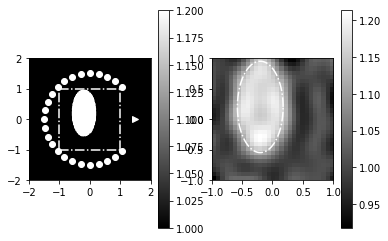

In [8]:
fig, axes = plt.subplots(1, 2)
pos1 = axes[0].imshow(epsilon, cmap=plt.cm.gray, interpolation='nearest',origin = 'lower',extent = extent)
fig.colorbar(pos1, ax=axes[0])

xsq = N.linspace(-1,1,100)
ysq = N.linspace(-1,1,100)

axes[0].plot(xsq,-N.ones_like(xsq),'w-.')
axes[0].plot(xsq,N.ones_like(xsq),'w-.')
axes[0].plot(N.ones_like(xsq),ysq,'w-.')
axes[0].plot(-N.ones_like(xsq),ysq,'w-.')

M = 25
MM = N.arange(1,M+1)
xm = []
ym = []
Tx = 0
for m in MM:
    phi_i = Tx*2*pi/TRANSMISOR_parameters.S
    phi_m = phi_i +pi/4.+(m-1)*3.*pi/(2.*(M-1))
    xm.append((rhoS)*N.cos(phi_m)) #Coordenada x antena transmisora
    ym.append((rhoS)*N.sin(phi_m)) #Coordenada y antena transmisora

axes[0].plot(N.asarray(xm)/landa,N.asarray(ym)/landa,'wo')
axes[0].plot(rhoS/landa,0.0,'w>')
#Posición de la elipse
cx=-0.06     #x-position of the center
cy=0.06    #y-position of the center
b=0.225     #radius on the x-axis
a=0.1125    #radius on the y-axis
t = N.linspace(0, 2*pi, 100)

pos2 = axes[1].imshow(((tau_estimado/(1.j*omega)+eps0)/(eps0)).real, cmap=plt.cm.gray, interpolation='nearest',origin = 'lower',extent = extent2)
fig.colorbar(pos2, ax=axes[1])
axes[1].plot((cx+a*N.cos(t))/landa,(cy+b*N.sin(t))/landa,'w-.')

plt.show()

Y finalmente la estimación en la región de interés con la elipse verdadera en línea punteada.